# Coursework 2 for Cardiac MR Image Segmentation (2020-2021)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [1]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

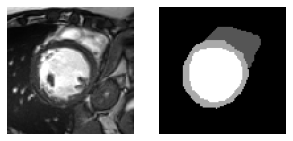

True

In [2]:
import os
import cv2 #import OpenCV

data_dir = './data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [3]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNSEG(nn.Module): # Define your model
    def __init__(self):
        super(CNNSEG, self).__init__()
        # fill in the constructor for your model here
        #self.conv =nn.Conv2d(1, 4, (3, 3), padding =1)###
        self.conv1 =nn.Conv2d(1, 64, (3, 3), padding =1)
        self.conv1_1 = nn.Conv2d(64, 64, (3, 3), padding=1)
        self.batch1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)

        
        self.conv2 = nn.Conv2d(64, 128, (3, 3,), padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, (3, 3), padding=1)
        self.batch2 = nn.BatchNorm2d(128)
         
        self.conv3 = nn.Conv2d(128, 256, (3, 3), padding=1)
        self.conv3_3 =nn.Conv2d(256, 256, (3, 3), padding=1)
        self.batch3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, (3, 3), padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, (3, 3), padding=1)
        self.batch4 = nn.BatchNorm2d(512)
        
        self.conv = nn.Conv2d(512, 718, (3, 3), padding=1)
        self.conv_v = nn.Conv2d(718, 718, (3, 3), padding=1)
        

        
        self.unpool = nn.MaxUnpool2d(2, 2)
        
        self.convv = nn.Conv2d(718, 512, (3, 3), padding=1)
        self.convv_vv = nn.Conv2d(512, 512, (3, 3), padding=1)
        
        self.conv5 = nn.Conv2d(512, 512, (3, 3), padding=1)
        self.conv5_5 = nn.Conv2d(512, 256, (3, 3), padding=1)
        self.batch5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(256, 128, (3, 3), padding=1)
        self.conv6_6 = nn.Conv2d(128, 128, (3, 3), padding=1)
        self.batch6 = nn.BatchNorm2d(128)
        
        self.conv7 = nn.Conv2d(128, 64, (3, 3), padding=1)
        self.conv7_7 = nn.Conv2d(64, 64, (3, 3), padding=1)
        self.batch7 = nn.BatchNorm2d(64)
        
        self.conv8 = nn.Conv2d(64, 4, (3, 3), padding=1)
        self.conv8_8 = nn.Conv2d(4, 4, (3, 3), padding=1)
        self.batch8 = nn.BatchNorm2d(4)
        
    def forward(self, x):
        # fill in the forward function for your model here
        #x=F.relu(self.conv(x)) ###
        x=F.relu(self.conv1(x))
        x=F.relu(self.batch1(self.conv1_1(x))) #64

        
        x, indices1 = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.batch2(self.conv2_2(x)))#128

        
        x, indices2 = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.batch3(self.conv3_3(x)))#256

        
        x, indices3 = self.pool(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.batch4(self.conv4_4(x)))

        
        x, indices4 = self.pool(x)
        x = F.relu(self.conv4_4(x))
        '''
        x = F.relu(self.conv(x))
        x = F.relu(self.conv_v(x))
        
        x, indices = self.pool(x)
        x = F.relu(self.conv_v(x))
        
        x = self.unpool(x, indices)
        x = F.relu(self.convv(x))
        x = F.relu(self.convv_vv(x))
        '''
        x = self.unpool(x, indices4)
        x = F.relu(self.conv5(x))
        x = F.relu(self.batch5(self.conv5_5(x)))
        
        
        x = self.unpool(x, indices3)
        x = F.relu(self.conv6(x)) #256
        x = F.relu(self.batch6(self.conv6_6(x)))
        
        x = self.unpool(x, indices2)
        x = F.relu(self.conv7(x)) #128
        x = F.relu(self.batch7(self.conv7_7(x)))
        
        x = self.unpool(x, indices1)
        x = F.relu(self.conv8(x))
        x = F.relu(self.batch8(self.conv8_8(x)))
        
        return x

model = CNNSEG() # We can now create a model using your defined segmentation model

### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

In [100]:
Loss = nn.CrossEntropyLoss() 
"write your loss function here"
import torch.optim as optim
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
"write your optimizer here"
print(model)
print(Loss)
print(optimizer)

CNNSEG(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1,

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [101]:
from torch.utils.data import DataLoader
import time
start = time.time()
data_path = './data/train'
num_workers = 4
batch_size = 4
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
###################################################
val_data_path = './data/val'
val_set = TrainDataset(val_data_path)
val_data_loader = DataLoader(dataset=val_set, batch_size=10)
#val_img = val_data_loader
for iteration, sample in enumerate(val_data_loader):
    val_img, val_mask = sample
val_img = val_img.unsqueeze(1)
accuracy_val = []

###################################################
# Fetch images and labels.  
for epoch in range(100):
    val_outputs = model.forward(val_img)
    val_predicted = torch.argmax(val_outputs.squeeze(1), dim=1)
    val_loss = Loss(val_outputs.float(), val_mask.long())
    print('--------------------')
    print('epoch: ' + str(epoch)+'::val_loss: ' + str(val_loss))
    
    for iteration, sample in enumerate(training_data_loader):
        correct = 0
        total = 0
        img, mask = sample
        ##show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze()) #visualise all data in training set
        ##plt.pause(1)
        img = img.unsqueeze(1)
        optimizer.zero_grad()
        # Write your FORWARD below
        # Note: Input image to your model and ouput the predicted mask and Your predicted mask should have 4 channels
        outputs = model.forward(img)

        # Then write your BACKWARD & OPTIMIZE below
        # Note: Compute Loss and Optimize
        loss = Loss(outputs.float(), mask.long())
        loss.backward()
        optimizer.step()
        ################################################
        '''
        val_outputs = model.forward(val_img)
        val_loss = Loss(val_outputs.float(), val_mask.long())
        print('val_loss:' + str(val_loss))
        val_predicted = torch.argmax(val_outputs.squeeze(1), dim=1)
        '''
        #print('train_loss' + str(Loss(outputs.float(), mask.long())))
print('time'+ str(time.time() - start))
#torch.save(model.state_dict(), "model_79.pth")

--------------------
epoch: 0::val_loss: tensor(1.5344, grad_fn=<NllLoss2DBackward>)
--------------------
epoch: 1::val_loss: tensor(1.1433, grad_fn=<NllLoss2DBackward>)
--------------------
epoch: 2::val_loss: tensor(1.0556, grad_fn=<NllLoss2DBackward>)
--------------------
epoch: 3::val_loss: tensor(1.0009, grad_fn=<NllLoss2DBackward>)
--------------------
epoch: 4::val_loss: tensor(0.9492, grad_fn=<NllLoss2DBackward>)
--------------------
epoch: 5::val_loss: tensor(0.9398, grad_fn=<NllLoss2DBackward>)
--------------------
epoch: 6::val_loss: tensor(0.9087, grad_fn=<NllLoss2DBackward>)
--------------------
epoch: 7::val_loss: tensor(0.8867, grad_fn=<NllLoss2DBackward>)
--------------------
epoch: 8::val_loss: tensor(0.8526, grad_fn=<NllLoss2DBackward>)
--------------------
epoch: 9::val_loss: tensor(0.8316, grad_fn=<NllLoss2DBackward>)
--------------------
epoch: 10::val_loss: tensor(0.8225, grad_fn=<NllLoss2DBackward>)
--------------------
epoch: 11::val_loss: tensor(0.7985, grad_fn

### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [102]:
import numpy as np
from torch.autograd import Variable

torch.Size([2, 1, 96, 96])


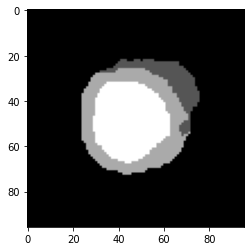

torch.Size([2, 1, 96, 96])


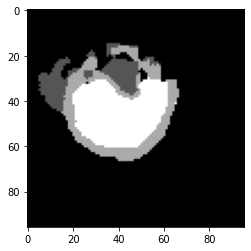

torch.Size([2, 1, 96, 96])


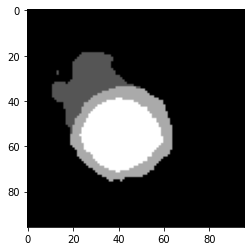

torch.Size([2, 1, 96, 96])


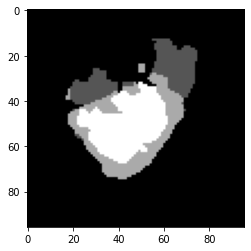

torch.Size([2, 1, 96, 96])


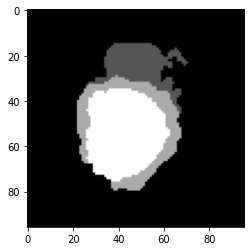

torch.Size([2, 1, 96, 96])


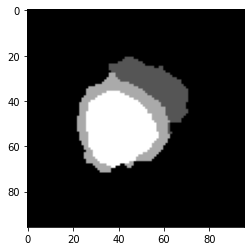

torch.Size([2, 1, 96, 96])


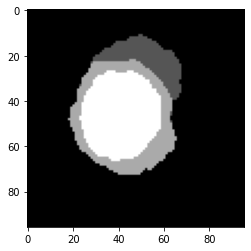

torch.Size([2, 1, 96, 96])


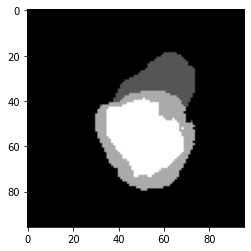

torch.Size([2, 1, 96, 96])


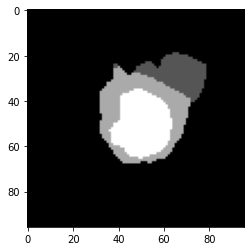

torch.Size([2, 1, 96, 96])


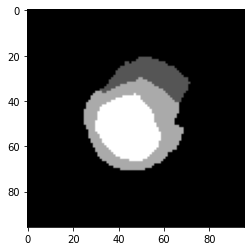

torch.Size([2, 1, 96, 96])


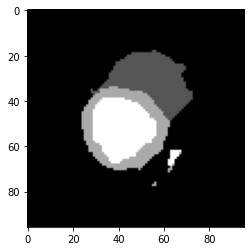

torch.Size([2, 1, 96, 96])


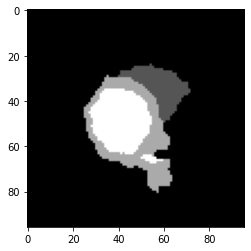

torch.Size([2, 1, 96, 96])


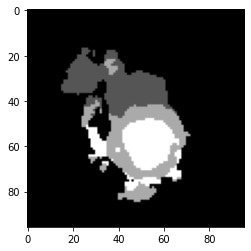

torch.Size([2, 1, 96, 96])


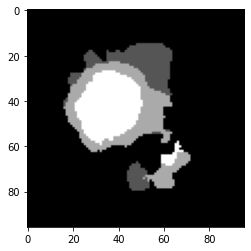

torch.Size([2, 1, 96, 96])


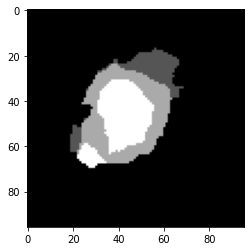

torch.Size([2, 1, 96, 96])


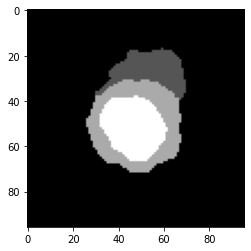

torch.Size([2, 1, 96, 96])


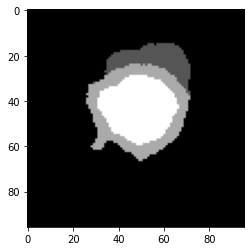

torch.Size([2, 1, 96, 96])


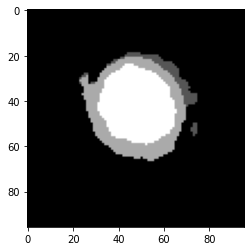

torch.Size([2, 1, 96, 96])


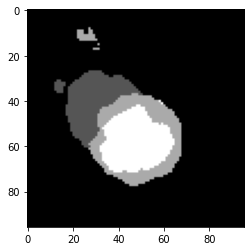

torch.Size([2, 1, 96, 96])


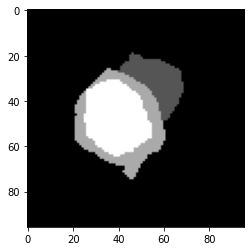

torch.Size([2, 1, 96, 96])


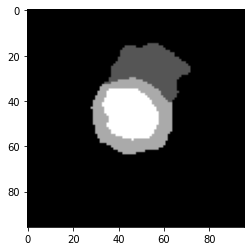

torch.Size([2, 1, 96, 96])


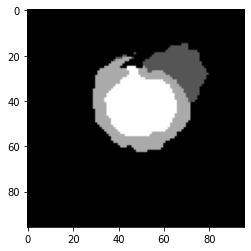

torch.Size([2, 1, 96, 96])


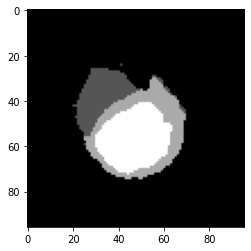

torch.Size([2, 1, 96, 96])


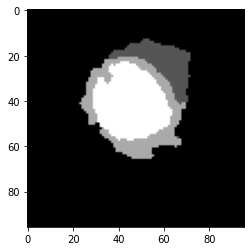

torch.Size([2, 1, 96, 96])


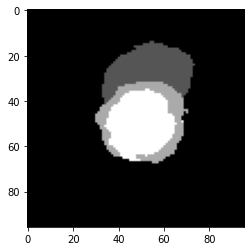

torch.Size([2, 1, 96, 96])


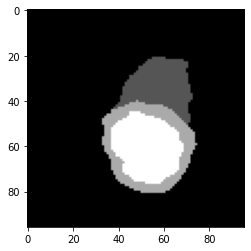

torch.Size([2, 1, 96, 96])


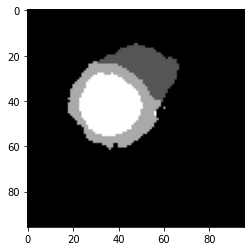

torch.Size([2, 1, 96, 96])


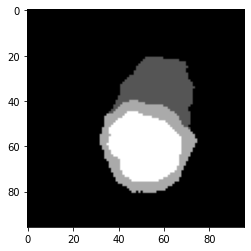

torch.Size([2, 1, 96, 96])


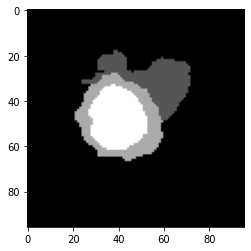

torch.Size([2, 1, 96, 96])


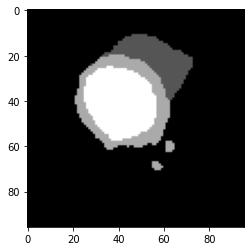

torch.Size([2, 1, 96, 96])


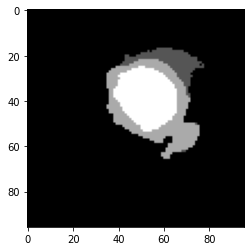

torch.Size([2, 1, 96, 96])


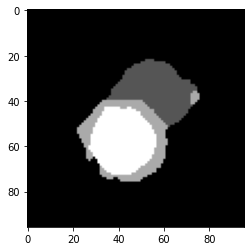

torch.Size([2, 1, 96, 96])


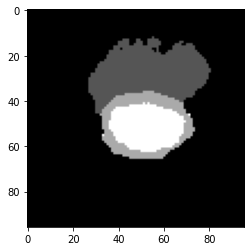

torch.Size([2, 1, 96, 96])


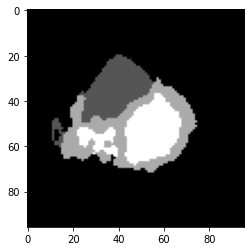

torch.Size([2, 1, 96, 96])


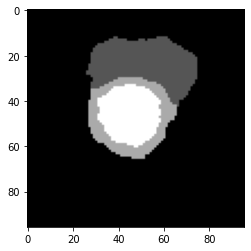

torch.Size([2, 1, 96, 96])


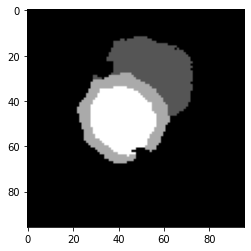

torch.Size([2, 1, 96, 96])


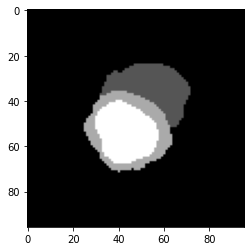

torch.Size([2, 1, 96, 96])


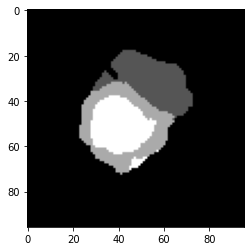

torch.Size([2, 1, 96, 96])


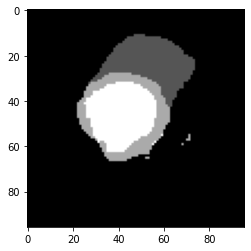

torch.Size([2, 1, 96, 96])


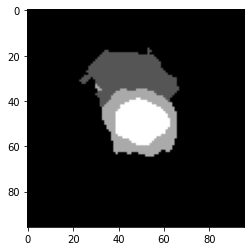

In [89]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
data_path = './data/test'
num_workers = 4
batch_size = 2

test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)
#model.load_state_dict(torch.load("model.pth"))
for iteration, sample in enumerate(test_data_loader):
    img = sample
    img = img.unsqueeze(1)##
    print(img.shape)
    img = model.forward(img)###
    
    img = torch.argmax(img.squeeze(), dim=1)##
    plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
    plt.pause(1)

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [103]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice


#print(val_predicted.size())
#print(val_mask.size())
accuracy = []
for i in range(10):
    #print(categorical_dice(np.array(val_predicted[i]), np.array(val_mask[i]), 2))
    accuracy.append(categorical_dice(np.array(val_predicted[i]), np.array(val_mask[i]), 2))
print('accuracy:' + str(np.mean(accuracy)))

accuracy:0.7353530331926643


### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()